c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


El código se está ejecutando en la GPU: NVIDIA GeForce GTX 1050


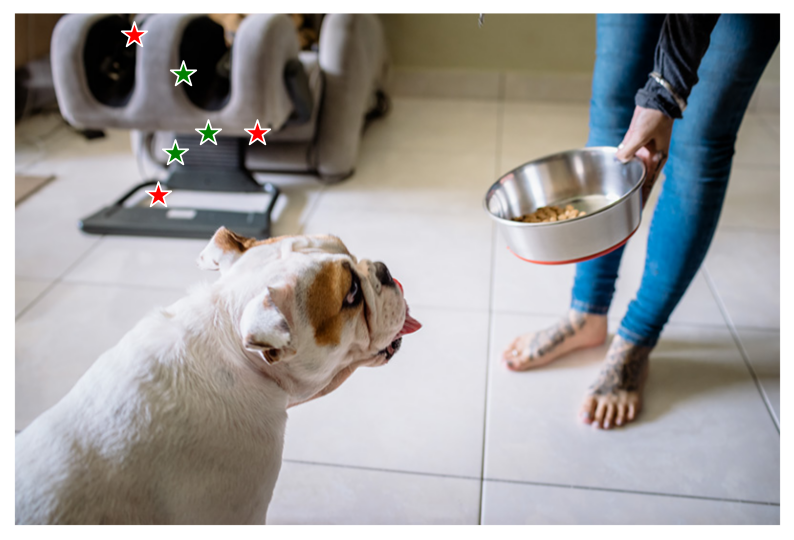

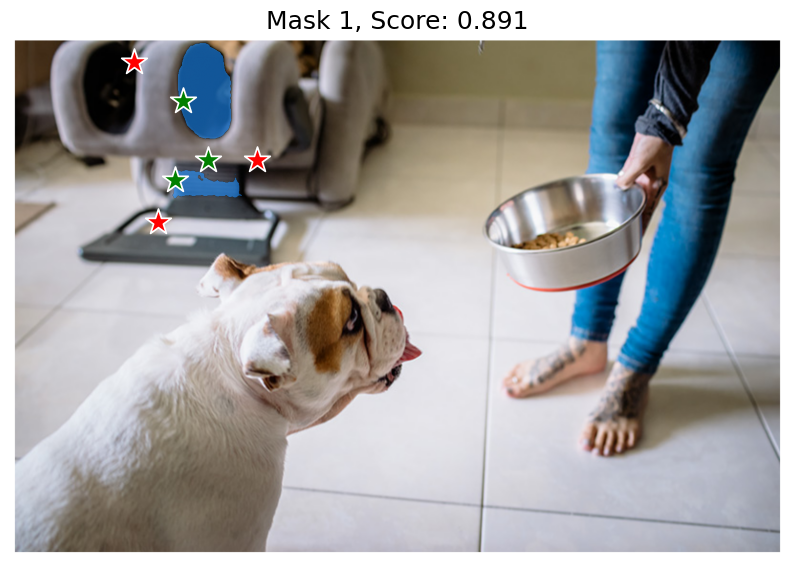

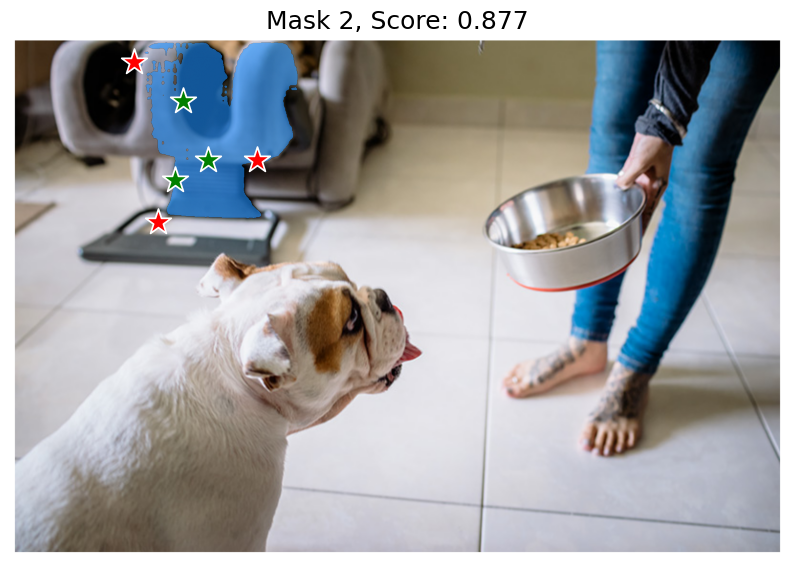

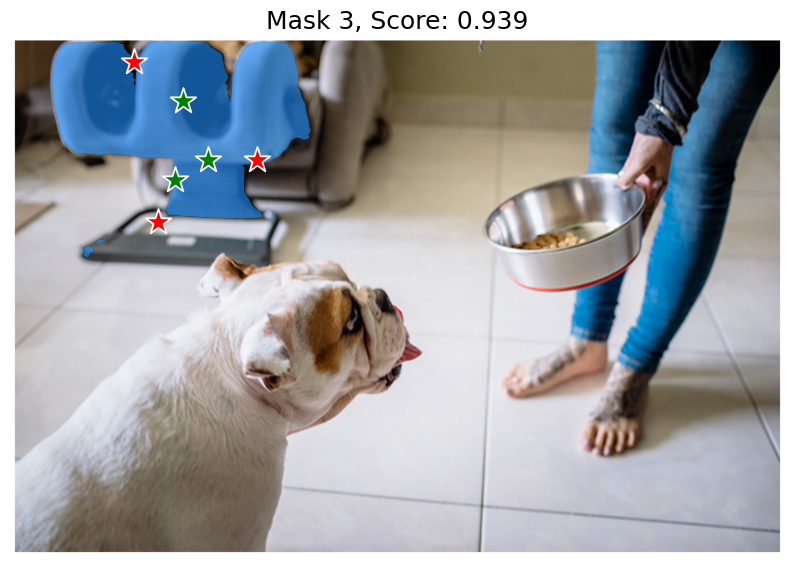

Elapsed time = 4018.4547901153564 ms


In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import sys
import io
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import torch


# params
model_size = "large" # small, medium, large
device = torch.device("cpu") # cuda:0, cpu
image_name = "dog.png"

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print(f"El código se está ejecutando en la GPU: {torch.cuda.get_device_name(current_device)}")
else:
    print("El código se está ejecutando en la CPU.")


# load image
image = cv2.imread('image_examples/' + image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# plotting methods
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

# get middle point of image
input_point = np.array([[300,375],[500,250],[250,50],[350,130],[400,250],[333,290]])
# input_point = np.array([[500, 375]])
input_label = np.array([0, 0, 0, 1, 1, 1])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

sys.path.append("..")

# download model checkpoint (https://github.com/facebookresearch/segment-anything#model-checkpoints)
if(model_size == "small"):
    sam_checkpoint = "model_checkpoint/sam_vit_b_01ec64.pth"
    model_type = "vit_b"

if(model_size == "medium"):
    sam_checkpoint = "model_checkpoint/sam_vit_l_0b3195.pth"
    model_type = "vit_l"

if(model_size == "large"):
    sam_checkpoint = "model_checkpoint/sam_vit_h_4b8939.pth"
    model_type = "vit_h"

# load model and send to device
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

#load predictor
predictor = SamPredictor(sam)

predictor.set_image(image)

# get time
start = time.time()


# predict mask
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()
    
    # Liberar memoria de la GPU
    torch.cuda.empty_cache()


# get time
end = time.time()
print('Elapsed time = ' + str((end - start)*1000) + ' ms')
